## Description
This notebook processes only the manually labelled datasets for testing purposes. Using BERT, each of these datasets is also labelled automatically to determine whether it represents mobility data or not. The results are visualized using a confusion matrix.
This approach aims to provide insights into how the process can be improved by modifying the keyword pool and the threshold.

The code was created with the assistance of ChatGPT-4.

In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define parameters
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
mobility_keywords_file = 'data/mobility_keywords_pool.txt'
inputdata_file = 'data/03_labelled_data.csv'
threshold = 0.5 # similarity threshold

## der threshold muss zu einer minimalen anzahl wörtern erfüllt sein

In [ ]:
df = pd.read_csv(inputdata_file, dtype={'mobilitydata_labelled': 'string'}, low_memory=False)

# Drop rows where 'mobilitydata_labelled' is empty (NaN)
df = df.dropna(subset=['mobilitydata_labelled'])

# Convert 'mobilitydata_labelled' to boolean type
df['mobilitydata_labelled'] = df['mobilitydata_labelled'].map({'True': True, 'False': False})

# Print the number of rows remaining after filtering
print(f"Number of labelled rows after filtering: {len(df)}")

Number of labelled rows after filtering: 6


In [6]:
# Read mobility keywords from the file
with open(mobility_keywords_file, 'r', encoding='utf-8') as file:
    mobility_keywords = [line.strip() for line in file if line.strip()]
   
# Convert keywords to vectors
keyword_embeddings = model.encode(mobility_keywords)

In [7]:
# Function for similarity checking
def check_similarity(text, keyword_embeddings, model, threshold):
    text_embedding = model.encode([text])
    similarities = cosine_similarity(text_embedding, keyword_embeddings)
    max_similarity = np.max(similarities)
    return max_similarity >= threshold, max_similarity

# Function to apply the similarity checking function to the DataFrame
def apply_similarity_check(row, keyword_embeddings, model, threshold):
    text = str(row['combined_DE_keywords'])
    is_mobility, similarity_score = check_similarity(text, keyword_embeddings, model, threshold)
    label = True if is_mobility else False
    return pd.Series([label, similarity_score])

In [8]:
# Define a function to count words
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    return 0  # Return 0 if the text is not a string

# Apply the function to the 'combined_DE_keywords' column
df['Word_Count'] = df['combined_DE_keywords'].apply(count_words)

In [10]:
# Apply the similarity checking function to the DataFrame
df[['Analysis Result', 'Similarity Score']] = df.apply(
    lambda row: apply_similarity_check(row, keyword_embeddings, model, threshold), axis=1
)

# Define categories based on confusion matrix results
df['Confusion_Matrix_Category'] = 'Unknown'
df.loc[(df['mobilitydata_labelled'] == True) & (df['Analysis Result'] == True), 'Confusion_Matrix_Category'] = 'True Positive'
df.loc[(df['mobilitydata_labelled'] == False) & (df['Analysis Result'] == False), 'Confusion_Matrix_Category'] = 'True Negative'
df.loc[(df['mobilitydata_labelled'] == False) & (df['Analysis Result'] == True), 'Confusion_Matrix_Category'] = 'False Positive'
df.loc[(df['mobilitydata_labelled'] == True) & (df['Analysis Result'] == False), 'Confusion_Matrix_Category'] = 'False Negative'

# Count the number of occurrences of each category
category_counts = df['Confusion_Matrix_Category'].value_counts()

# Print the result
print(f"""
Confusion Matrix Counts:
-------------------------
True Positive  (TP): {category_counts.get('True Positive', 0)}  - Predicted as 'Mobility Data' and is actually Mobility Data
True Negative  (TN): {category_counts.get('True Negative', 0)}  - Predicted as 'Not Mobility Data' and is actually Not Mobility Data
False Positive (FP): {category_counts.get('False Positive', 0)}  - Predicted as 'Mobility Data' but is actually Not Mobility Data
False Negative (FN): {category_counts.get('False Negative', 0)}  - Predicted as 'Not Mobility Data' but is actually Mobility Data
""")

# optional: display the dataframe
# display(df[['dataset_title_DE', 'mobilitydata_labelled', 'Analysis Result', 'Similarity Score']])



Confusion Matrix Counts:
-------------------------
True Positive  (TP): 0  - Predicted as 'Mobility Data' and is actually Mobility Data
True Negative  (TN): 3  - Predicted as 'Not Mobility Data' and is actually Not Mobility Data
False Positive (FP): 2  - Predicted as 'Mobility Data' but is actually Not Mobility Data
False Negative (FN): 1  - Predicted as 'Not Mobility Data' but is actually Mobility Data



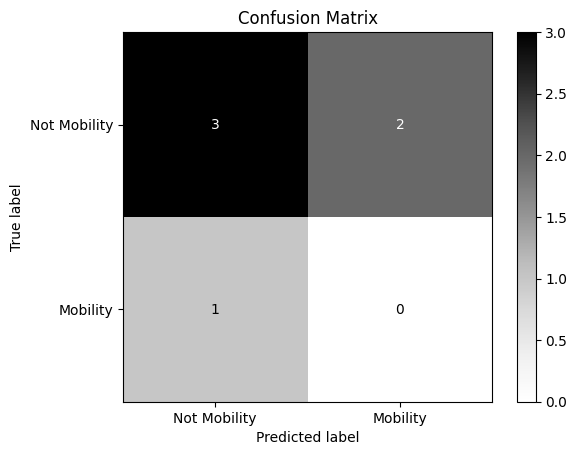

In [14]:
# Generate the confusion matrix using boolean columns
cm = confusion_matrix(df['mobilitydata_labelled'], df['Analysis Result'])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Mobility", "Mobility"])
disp.plot(cmap=plt.cm.Greys)
plt.title('Confusion Matrix')
plt.show()


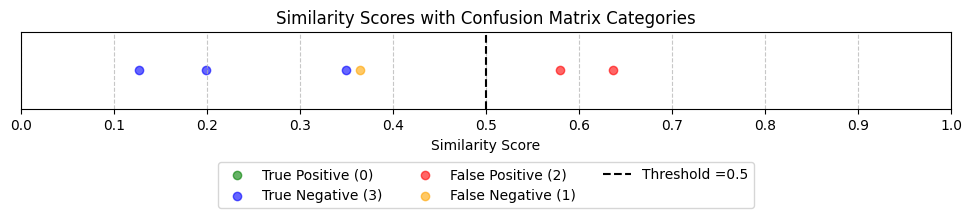

In [12]:
# Define colors for each category
colors = {
    'True Positive': 'green',
    'True Negative': 'blue',
    'False Positive': 'red',
    'False Negative': 'orange'
}

# Create a scatter plot
plt.figure(figsize=(12, 1))
for category, color in colors.items():
    subset = df[df['Confusion_Matrix_Category'] == category]
    count = category_counts.get(category, 0)
    plt.scatter(subset['Similarity Score'], [0] * len(subset), color=color, label=f"{category} ({count})", alpha=0.6)

# Plot the threshold line
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold ={threshold}')

# Plot formatting
plt.title('Similarity Scores with Confusion Matrix Categories')
plt.xlabel('Similarity Score')
plt.xlim(0, 1)
plt.yticks([])
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=3)
plt.show()


In [15]:
# Display the DataFrame filtered for False Positives
print("False Positives:")
display(df[df['Confusion_Matrix_Category'] == 'False Positive'][['combined_DE_keywords', 'Similarity Score']])

print("False Negatives:")
# Display the DataFrame filtered for False Negatives
display(df[df['Confusion_Matrix_Category'] == 'False Negative'][['combined_DE_keywords', 'Similarity Score']])


False Positives:


,combined_DE_keywords,Similarity Score
3438,erstzugelassene fahrzeuge nach fahrzeuggruppea...,0.636093
20037,NaN,0.579761


False Negatives:


,combined_DE_keywords,Similarity Score
29035,geobasisdaten opendataswiss,0.364495
